# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [ ]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250504_nvidia_forecast.csv
Forecast data saved to 20250504_nvidia_forecast.csv
Current stock price of nvidia is 114.5 USD / 101.3 EUR


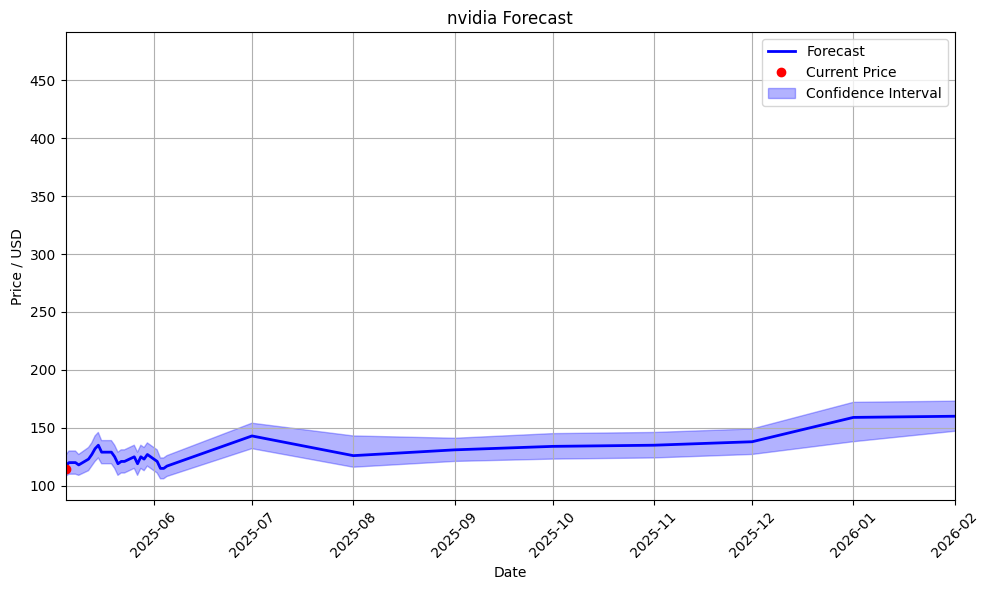

In [2]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250504_rhm-aktie_forecast.csv
Forecast data saved to 20250504_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1770.81 USD / 1566.64 EUR


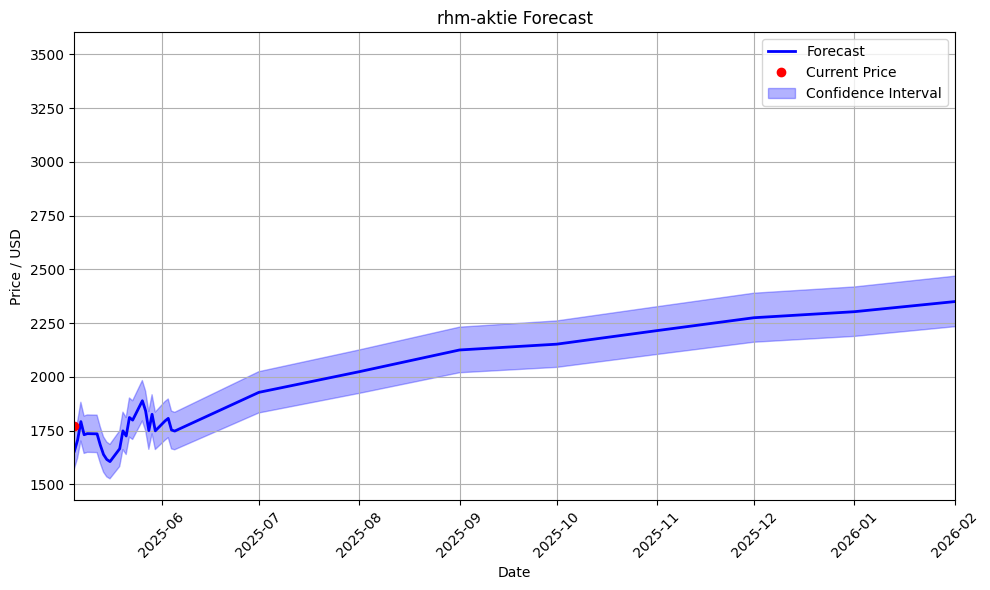

In [3]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250504_tesla_forecast.csv
Forecast data saved to 20250504_tesla_forecast.csv
Current stock price of tesla is 287.21 USD / 254.09 EUR


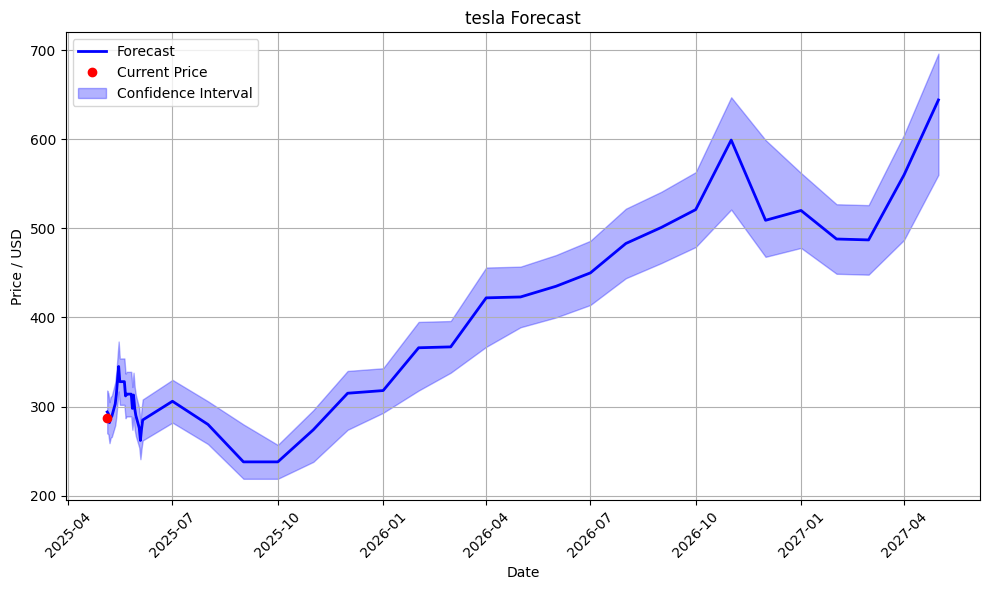

In [4]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250504_netflix_forecast.csv
Forecast data saved to 20250504_netflix_forecast.csv
Current stock price of netflix is 1156.49 USD / 1023.15 EUR


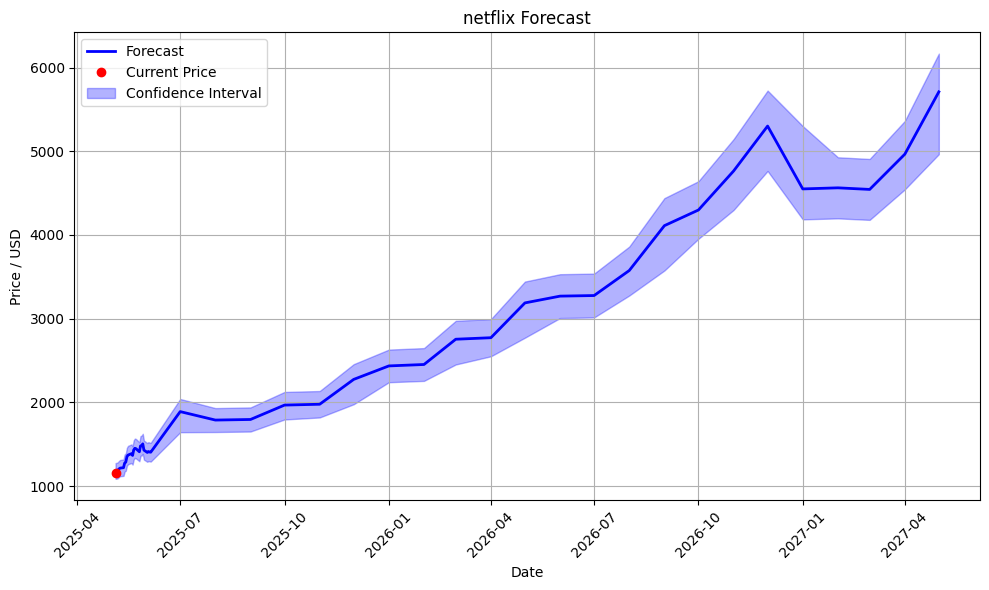

In [5]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250504_wmt-stock_forecast.csv
Forecast data saved to 20250504_wmt-stock_forecast.csv
Current stock price of wmt-stock is 98.75 USD / 87.36 EUR


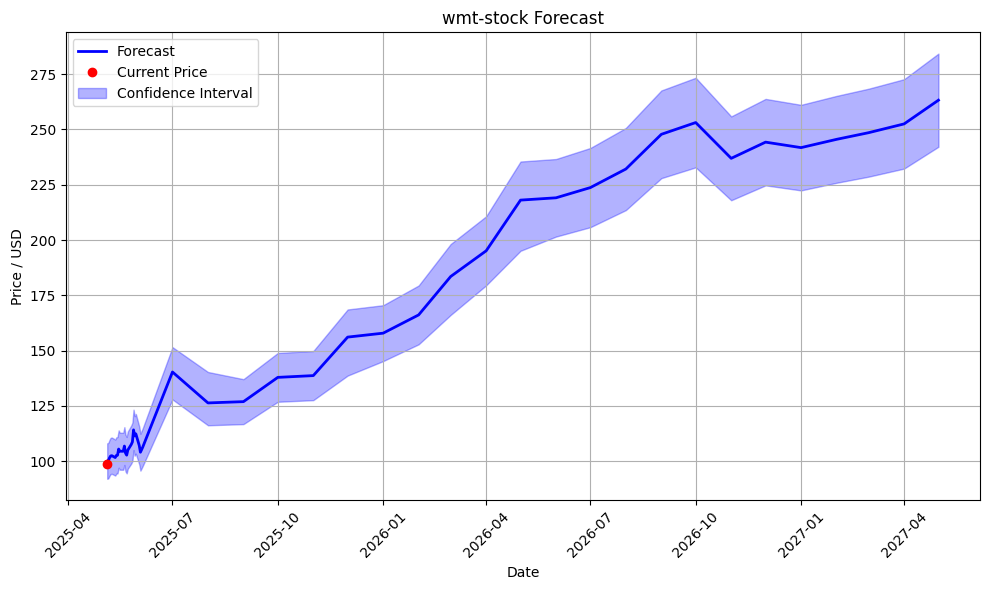

In [6]:
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250504_xpeng_forecast.csv
Forecast data saved to 20250504_xpeng_forecast.csv
Current stock price of xpeng is 19.76 USD / 17.48 EUR


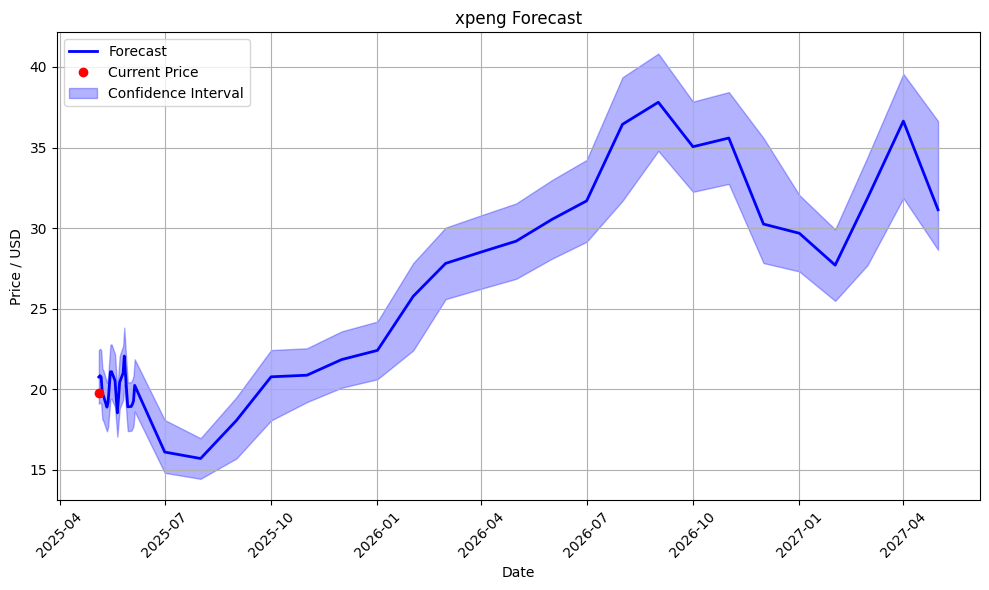

In [7]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250504_mo-stock_forecast.csv
Forecast data saved to 20250504_mo-stock_forecast.csv
Current stock price of mo-stock is 59.61 USD / 52.74 EUR


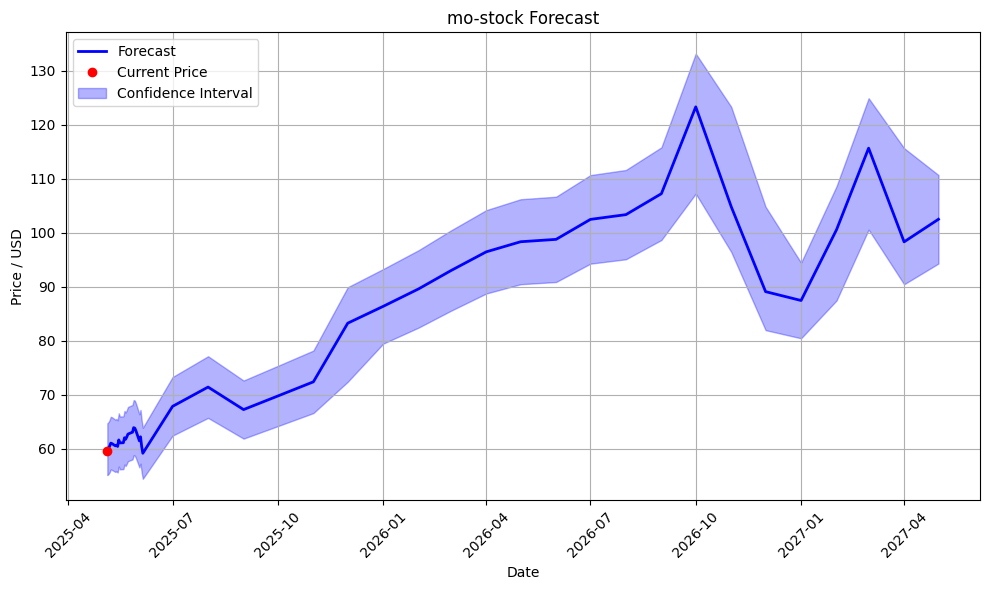

In [8]:
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()